In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv, find_dotenv
import re
import os

In [2]:
## Connection
_ = load_dotenv(find_dotenv())

USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

In [3]:
def get_connection(dbname, host, port, user, password):
    try:
        conn = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                                user,password,host,port,dbname ))
        # conn.set_session(autocommit=True)
        print(f"Connection to PostgreSQL {host} success")

    except Exception as err:
        print("ERR TYPE:", err)
        print(f'''ERR EXCEPTION:{err}''')
        conn = None

    return conn

In [4]:
engine = get_connection(DBNAME, HOST, PORT, USER, PASSWORD)

Connection to PostgreSQL aws-1-ap-southeast-2.pooler.supabase.com success


In [5]:
# Fungsi untuk menjalankan query SQL dan mengembalikan hasil dalam bentuk DataFrame
def sql_df(query, engine):
    try:
        return pd.read_sql(query, con=engine)
    except Exception as e:
        # Menangani error jika query gagal dijalankan
        print(f"Error executing query: {e}")
        return None

## **Step 1 - Discover the Pattern of Success**

In [6]:
query = "select * from employees"
employee = sql_df(query, engine)
employee.head()

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


In [7]:
query = "SELECT * FROM competencies_yearly"
competencies_yearly = sql_df(query, engine)
competencies_yearly.head()

,employee_id,score,pillar_code,year
0,EMP100000,2.0,GDR,2021
1,EMP100001,NaN,GDR,2021
2,EMP100002,1.0,GDR,2021
3,EMP100003,NaN,GDR,2021
4,EMP100004,3.0,GDR,2021


In [8]:
query = "SELECT * FROM dim_competency_pillars"
dim_competency_pillars = sql_df(query, engine)
dim_competency_pillars.head()

,pillar_code,pillar_label
0,GDR,Growth Drive & Resilience
1,CEX,Curiosity & Experimentation
2,IDS,Insight & Decision Sharpness
3,QDD,Quality Delivery Discipline
4,STO,Synergy & Team Orientation


In [9]:
query = "SELECT * FROM profiles_psych"
profiles_psych = sql_df(query, engine)
profiles_psych.head()

,employee_id,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki
0,EMP100000,86,75,SI,Steadiness-Influencer,NaN,94.0,33.0,2
1,EMP100001,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3
2,EMP100002,66,38,DC,Dominant-Conscientious,NaN,109.0,20.0,3
3,EMP100003,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3
4,EMP100004,75,100,NaN,Steadiness-Conscientious,INTJ,134.0,21.0,9


In [10]:
query = "SELECT * FROM strengths"
strengths = sql_df(query, engine)
strengths.head()

,employee_id,rank,theme
0,EMP100000,1,NaN
1,EMP100001,1,Responsibility
2,EMP100002,1,Restorative
3,EMP100003,1,Belief
4,EMP100004,1,Deliberative


In [11]:
query = """
select 
    rating, 
    count(*) as total_karyawan
from performance_yearly
where year = 2024
group by rating
order by rating desc;
"""

rating = sql_df(query, engine)
rating

,rating,total_karyawan
0,NaN,134
1,99.0,2
2,6.0,2
3,5.0,196
4,4.0,542
5,3.0,676
6,2.0,323
7,1.0,131
8,0.0,4


| Nilai | Status                                          |
| ----- | ----------------------------------------------- |
| 1–5   | Valid 👍                                        |
| 6     | Outlier/Error                                   |
| 99    | Sangat Outlier (mungkin dummy / missing marker) |
| NaN   | Missing data                                    |

Goals:<br>
• Fokus ke data performa yang benar<br>
• Tanpa menghapus terlalu agresif

Solusi:<br>
filter hanya rating 1–5 sebagai dataset valid analisis.

In [12]:
query = """
select 
    rating, 
    count(*) as total_karyawan
from performance_yearly
where year = 2024
  and rating between 1 and 5
group by rating
order by rating desc;
"""
rating = sql_df(query, engine)
rating

,rating,total_karyawan
0,5.0,196
1,4.0,542
2,3.0,676
3,2.0,323
4,1.0,131


### **Section A: Contextual Factors**
Apakah benar high performers memiliki pengalaman lebih lama?

In [13]:
query = """
select 
  case when pr.rating = 5 then 'High Performer'
       else 'Others'
  end as group_label,
  avg(e.years_of_service_months) as avg_yos_months,
  count(*) as total
from employees e
join performance_yearly pr 
  on pr.employee_id = e.employee_id 
 and pr.year = 2024
where pr.rating between 1 and 5
group by group_label;
"""
avg_yos_months = sql_df(query, engine)
avg_yos_months

,group_label,avg_yos_months,total
0,High Performer,50.72449,196
1,Others,50.02811,1672


Pengalaman bukan faktor utama. Ada faktor lain yang harus dipahami dan dikembangkan.<br>
🎯 Kesimpulan awal:<br>
✅ Years of service bukan indikator kuat kesuksesan<br>
⏩ Kita harus menggeser fokus ke aspek kompetensi & psikometri

In [14]:
query = ("""
    select 
      case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
      e.years_of_service_months::int as yos_months
    from performance_yearly pr
    join employees e on e.employee_id = pr.employee_id
    where pr.year = 2024
      and pr.rating between 1 and 5
""")
df_yos = sql_df(query, engine)
df_yos = df_yos.dropna(subset=["yos_months"]).copy()

df_yos.head()

,group_label,yos_months
0,Others,64
1,Others,16
2,Others,15
3,Others,34
4,Others,66


In [15]:
summary = (
    df_yos
    .groupby("group_label")["yos_months"]
    .agg(n="count", mean="mean", p25=lambda s: s.quantile(0.25), median="median", p75=lambda s: s.quantile(0.75))
    .round(2)
    .reset_index()
)
summary

,group_label,n,mean,p25,median,p75
0,High Performer,196,50.72,29.0,52.0,69.0
1,Others,1672,50.03,32.0,49.0,66.0


C:\Users\user\AppData\Local\Temp\ipykernel_17256\1903818820.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


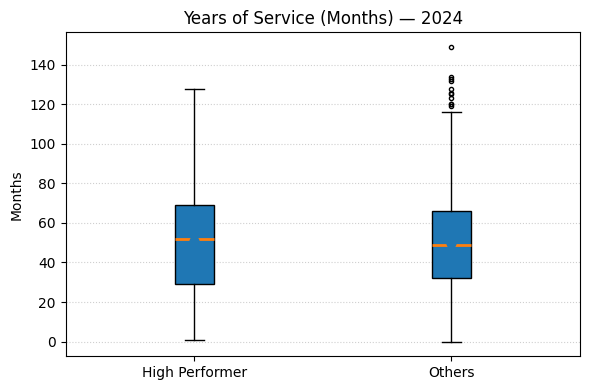

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

groups = ["High Performer", "Others"]
data = [df_yos.loc[df_yos["group_label"] == g, "yos_months"].values for g in groups]

# Boxplot
box = plt.boxplot(
    data, 
    labels=groups, 
    showmeans=False, 
    patch_artist=True,  # agar bisa sedikit shading default
    medianprops={"linewidth": 2},
    boxprops={"linewidth": 1},
    whiskerprops={"linewidth": 1},
    capprops={"linewidth": 1},
    flierprops={"markersize": 3}
)

# Titik mean per grup
means = [np.mean(d) if len(d) else np.nan for d in data]
plt.scatter([1, 2], means, marker="o", s=40, zorder=3)

plt.title("Years of Service (Months) — 2024")
plt.ylabel("Months")
plt.grid(True, axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

Years of Service tidak menunjukkan perbedaan berarti antara High Performers dan Others.
Senioritas bukan penentu utama performa tinggi di organisasi ini.
Artinya, HR dan leaders perlu fokus pada kapabilitas & perilaku, bukan pada masa kerja semata.

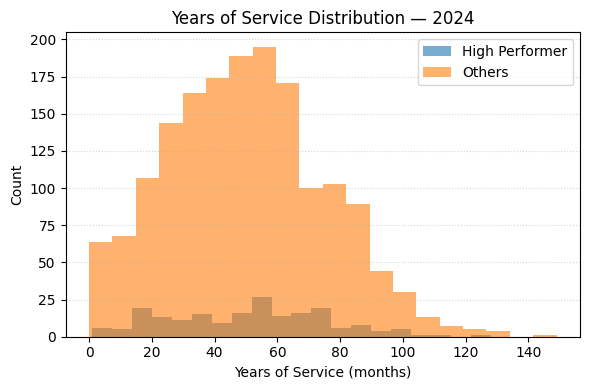

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
bins = 20

plt.hist(df_yos[df_yos['group_label']=='High Performer']['yos_months'], 
         bins=bins, alpha=0.6, label='High Performer')
plt.hist(df_yos[df_yos['group_label']=='Others']['yos_months'], 
         bins=bins, alpha=0.6, label='Others')

plt.xlabel("Years of Service (months)")
plt.ylabel("Count")
plt.title("Years of Service Distribution — 2024")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Distribusi Years of Service High Performers hampir identik dengan Others.
Artinya, tingginya performa tidak dipengaruhi masa kerja.
Karyawan baru berpotensi sama besarnya untuk menjadi top performers.

### **Section B — Psychometric profiles**

In [18]:
query = """
WITH perf AS (
  SELECT 
    employee_id,
    AVG(rating) AS avg_rating
  FROM performance_yearly
  WHERE year = 2024
  GROUP BY employee_id
)

SELECT
  CASE WHEN p.avg_rating = 5 THEN 'High Performer' ELSE 'Others' END AS group_label,
  AVG(ps.iq) FILTER (WHERE ps.iq IS NOT NULL) AS avg_iq,
  AVG(ps.gtq) FILTER (WHERE ps.gtq IS NOT NULL) AS avg_gtq,
  AVG(ps.pauli) AS avg_pauli,
  AVG(ps.faxtor) AS avg_faxtor,
  COUNT(ps.iq) FILTER (WHERE ps.iq IS NOT NULL) AS total_sample
FROM perf p
LEFT JOIN profiles_psych ps ON ps.employee_id = p.employee_id
GROUP BY group_label;
"""
sql_df(query, engine)


,group_label,avg_iq,avg_gtq,avg_pauli,avg_faxtor,total_sample
0,Others,NaN,NaN,59.735943,60.26516,1814
1,High Performer,NaN,NaN,62.178571,60.44898,196


Berdasarkan hasil query diatas terlihat bahwa avg_iq dan juga avg_gtq NaN, hal tersebut mungkin karena terdapat nilai NaN pada kolom IQ dan GTQ. Mari kita cek lebih lanjut

In [19]:
query = """
SELECT
  SUM(CASE WHEN IQ = 'NaN' THEN 1 ELSE 0 END) AS JML_IQ_NAN,
  SUM(CASE WHEN GTQ = 'NaN' THEN 1 ELSE 0 END) AS JML_GTQ_NAN
FROM profiles_psych;
"""
sql_df(query, engine)

,jml_iq_nan,jml_gtq_nan
0,456,332


Berdasarkan hasil query diatas, terlihat bahwa kolom IQ memiliki nilai NaN sebanyak 456 baris dan kolom GTQ memiliki nilai NaN sebanyak 332 baris. Nilai IQ & GTQ sebenarnya bukan angka valid, tapi string 'NaN' yang dikonversi jadi double precision. Postgres menyimpannya sebagai NaN yang tidak bisa ikut perhitungan AVG, sehingga hasil AVG menjadi NULL.

In [20]:
query = """
WITH perf AS (
  SELECT 
    employee_id,
    AVG(rating) AS avg_rating
  FROM performance_yearly
  WHERE year = 2024
  GROUP BY employee_id
)

SELECT
  CASE WHEN p.avg_rating = 5 THEN 'High Performer' ELSE 'Others' END AS group_label,
  AVG(ps.iq) FILTER (WHERE ps.iq IS NOT NULL AND ps.iq <> 'NaN') AS avg_iq,
  AVG(ps.gtq) FILTER (WHERE ps.gtq IS NOT NULL AND ps.gtq <> 'NaN') AS avg_gtq,
  AVG(ps.pauli) AS avg_pauli,
  AVG(ps.faxtor) AS avg_faxtor,
  COUNT(ps.iq) FILTER (WHERE ps.iq IS NOT NULL AND ps.iq <> 'NaN') AS total_sample
FROM perf p
LEFT JOIN profiles_psych ps ON ps.employee_id = p.employee_id
GROUP BY group_label;
"""
sql_df(query, engine)

,group_label,avg_iq,avg_gtq,avg_pauli,avg_faxtor,total_sample
0,Others,109.586231,27.493088,59.735943,60.26516,1409
1,High Performer,108.806897,27.194969,62.178571,60.44898,145


Performansi tinggi di organisasi ini tidak ditentukan oleh kemampuan kognitif umum (IQ/GTQ). Faktor pembeda utamanya adalah stamina mental yang diukur melalui Pauli Test, menggambarkan konsistensi kerja dalam situasi tekanan. Kesimpulannya Cuma Pauli yang layak masuk TGV: Cognitive Efficiency di formula nanti.

In [21]:
df_pauli = (
    df_yos[["group_label"]]
    .copy()
    .merge(
        pd.read_sql("""
            select pr.employee_id,
                   pr.rating,
                   case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
                   ps.pauli
            from performance_yearly pr
            join profiles_psych ps on ps.employee_id = pr.employee_id
            where pr.year = 2024
              and pr.rating between 1 and 5
              and ps.pauli is not null
        """, engine),
    on="group_label",
    how="inner"
    )
)
df_pauli

,group_label,employee_id,rating,pauli
0,Others,EMP100000,3.0,86
1,Others,EMP100001,4.0,48
2,Others,EMP100003,1.0,39
3,Others,EMP100004,2.0,75
4,Others,EMP100005,3.0,69
...,...,...,...,...
2833995,Others,DUP1942,2.0,55
2833996,Others,DUP2096,4.0,27
2833997,Others,DUP4177,4.0,41
2833998,Others,DUP9801,2.0,37


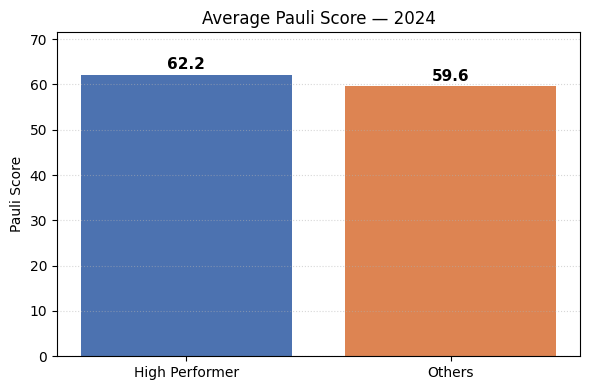

In [22]:
means = df_pauli.groupby("group_label")["pauli"].mean().values
groups = ["High Performer", "Others"]

plt.figure(figsize=(6,4))
bars = plt.bar(groups, means, color=["#4c72b0","#dd8452"])

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.5, 
        f"{height:.1f}", 
        ha='center', va='bottom', fontsize=11, fontweight='bold'
    )

plt.ylabel("Pauli Score")
plt.title("Average Pauli Score — 2024")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.ylim(0, max(means)*1.15)  # gives some headroom
plt.tight_layout()
plt.show()

High Performers memiliki skor Pauli lebih tinggi,
mencerminkan stamina mental serta ketahanan bekerja dalam tugas berulang.
Perbedaan ini mendukung observasi bahwa eksekusi dan konsistensi kerja menjadi landasan kesuksesan.

C:\Users\user\AppData\Local\Temp\ipykernel_17256\1554729504.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


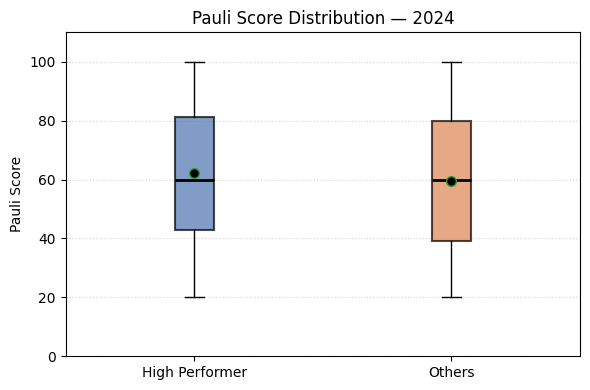

In [23]:
hp_pauli = df_pauli[df_pauli['group_label']=='High Performer']['pauli'].values
oth_pauli = df_pauli[df_pauli['group_label']=='Others']['pauli'].values

hp = hp_pauli
oth = oth_pauli

plt.figure(figsize=(6,4))
groups = ["High Performer", "Others"]

# Boxplot with colored boxes
box = plt.boxplot(
    [hp, oth],
    labels=groups,
    patch_artist=True,
    showmeans=True,
    meanprops={"marker":"o", "markersize":7, "markerfacecolor":"black"},
    medianprops={"linewidth":2, "color":"black"},
    boxprops={"linewidth":1.5},
    whiskerprops={"linewidth":1},
    capprops={"linewidth":1},
    flierprops={"markersize":3, "markerfacecolor":"grey", "alpha":0.4}
)

# Custom box colors
colors = ['#4c72b0', '#dd8452']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel("Pauli Score")
plt.title("Pauli Score Distribution — 2024")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.ylim(0, 110)  # tightened limits for clarity
plt.tight_layout()
plt.show()

Distribusi Pauli karyawan High Performers cenderung lebih tinggi dan lebih konsisten.
Ini mengindikasikan endurance dan fokus kerja yang lebih baik ketika menghadapi beban tugas intensif.

In [24]:
def cohens_d(x, y):
    # sampel mean & std
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)

    # pooled standard deviation
    pooled_std = np.sqrt(((nx-1)*std_x**2 + (ny-1)*std_y**2) / (nx + ny - 2))

    return (mean_x - mean_y) / pooled_std

d_pauli = cohens_d(hp_pauli, oth_pauli)
d_pauli

np.float64(0.10754637680683218)

Perbedaan Pauli antara High Performers dan Others memiliki effect size rendah (d ≈ 0.11).
Cognitive endurance mendukung performa, namun tidak menjadi penentu utamanya.

In [25]:
query = """
select 
    case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
    ps.scale_code,
    avg(ps.score) FILTER (WHERE ps.score IS NOT NULL AND ps.score <> 'NaN') as avg_score
from papi_scores ps
join performance_yearly pr
  on pr.employee_id = ps.employee_id
where pr.year = 2024
  and pr.rating between 1 and 5
group by 1,2
order by ps.scale_code;
"""
df_papi = sql_df(query, engine)
df_papi.head()

,group_label,scale_code,avg_score
0,Others,Papi_A,5.058366
1,High Performer,Papi_A,5.005435
2,High Performer,Papi_B,4.740741
3,Others,Papi_B,4.938602
4,High Performer,Papi_C,4.972973


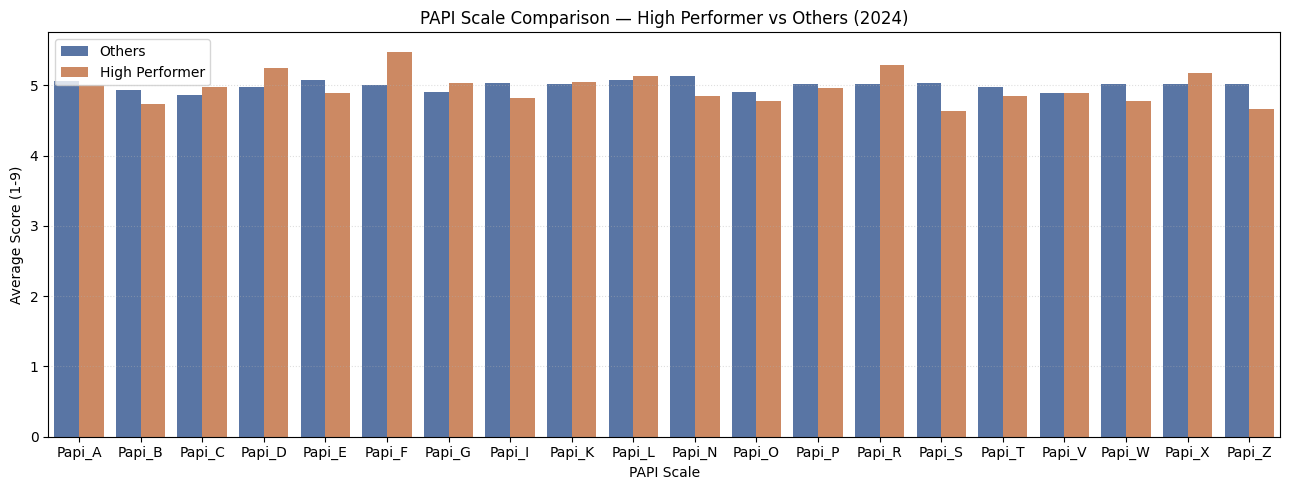

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(13,5))
sns.barplot(
    data=df_papi,
    x="scale_code",
    y="avg_score",
    hue="group_label",
    palette=["#4c72b0","#dd8452"]
)

plt.title("PAPI Scale Comparison — High Performer vs Others (2024)")
plt.ylabel("Average Score (1-9)")
plt.xlabel("PAPI Scale")
plt.grid(axis="y", linestyle=":", alpha=0.4)
plt.legend(title="")
plt.tight_layout()
plt.show()

Preferensi gaya kerja yang diukur dengan PAPI menunjukkan perbedaan minimal
antara Karyawan Berkinerja Tinggi dan Lainnya.
Hal ini menyiratkan bahwa kecocokan kepribadian tidak secara signifikan mendorong kesuksesan di tingkat organisasi.

### **Section C — Competency Pillars**

In [27]:
query = """
select
  case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
  c.pillar_code,
  avg(c.score) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as avg_score,
  count(*) as sample_count
from competencies_yearly c
join performance_yearly pr
  on pr.employee_id = c.employee_id
 and pr.year = c.year
where c.year = 2024
  and pr.rating between 1 and 5
group by 1,2
order by c.pillar_code, group_label;
"""
df_comp = sql_df(query, engine)
df_comp

,group_label,pillar_code,avg_score,sample_count
0,High Performer,CEX,4.697802,196
1,Others,CEX,3.073616,1672
2,High Performer,CSI,4.634831,196
3,Others,CSI,2.994832,1672
4,High Performer,FTC,4.698324,196
5,Others,FTC,3.145172,1672
6,High Performer,GDR,4.679348,196
7,Others,GDR,3.345207,1672
8,High Performer,IDS,4.644068,196
9,Others,IDS,3.044070,1672


| Pilar   |   HP | Others |       Gap | Insight Singkat                                 |
| ------- | ---: | -----: | --------: | ----------------------------------------------- |
| **QDD** | 5.18 |   3.13 | **+2.05** | Problem Solving / Quality Driven: pembeda utama |
| **FTC** | 4.70 |   3.15 | **+1.55** | Fast Execution / Action: kecepatan kerja        |
| **CEX** | 4.70 |   3.07 | **+1.63** | Customer Experience: orientasi eksternal        |
| **CSI** | 4.63 |   2.99 | **+1.64** | Collaboration & Service                         |
| **GDR** | 4.68 |   3.35 |     +1.33 | Leadership essentials                           |
| **LIE** | 4.66 |   3.22 |     +1.45 | Integrity & Ethics                              |
| **SEA** | 4.73 |   3.18 |     +1.55 | Self-Adaptability & Agility                     |
| **VCU** | 4.60 |   3.19 |     +1.41 | Value Creation Mindset                          |
| **IDS** | 4.64 |   3.04 |     +1.60 | Innovation & Problem Solving                    |
| **STO** | 4.58 |   3.05 |     +1.53 | Strategic Orientation                           |

High Performers unggul secara konsisten di semua competency pillars, terutama pada kemampuan problem solving, eksekusi cepat, dan orientasi pelanggan.

Karyawan berprestasi unggul akan berkembang dengan memecahkan masalah dengan lebih baik, bertindak lebih cepat,
dan menciptakan nilai yang lebih tinggi bagi pelanggan.

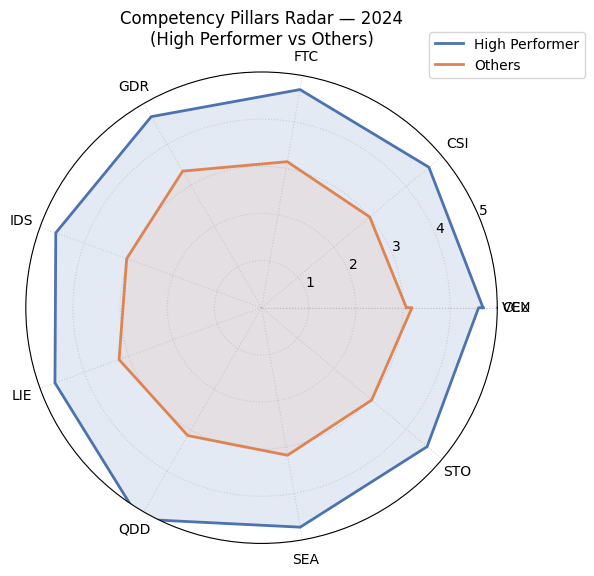

In [28]:
# Pivot data jadi satu baris per group
pivot = df_comp.pivot(index="group_label", columns="pillar_code", values="avg_score")
pivot = pivot[sorted(pivot.columns)]  # agar urut alfabet

# Siapkan data radar
labels = pivot.columns.tolist()
hp_values = pivot.loc["High Performer"].values
oth_values = pivot.loc["Others"].values

# Radar perlu penutupan lingkaran
hp = np.concatenate((hp_values, [hp_values[0]]))
oth = np.concatenate((oth_values, [oth_values[0]]))
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=True)
angles = np.concatenate((angles, [angles[0]]))

# Plot radar
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, hp, linewidth=2, label="High Performer", color="#4c72b0")
ax.fill(angles, hp, alpha=0.15, color="#4c72b0")

ax.plot(angles, oth, linewidth=2, label="Others", color="#dd8452")
ax.fill(angles, oth, alpha=0.10, color="#dd8452")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 5)  # range score
ax.set_title("Competency Pillars Radar — 2024\n(High Performer vs Others)", pad=20)

ax.grid(True, linestyle=":", alpha=0.5)
plt.legend(loc='upper right', bbox_to_anchor=(1.20, 1.10))
plt.tight_layout()
plt.show()


High Performers unggul di seluruh kompetensi inti,
terutama dalam eksekusi cepat, pemecahan masalah strategis, dan orientasi pelanggan.
Soft skills membedakan performa sukses jauh lebih besar ketimbang cognitive metrics.

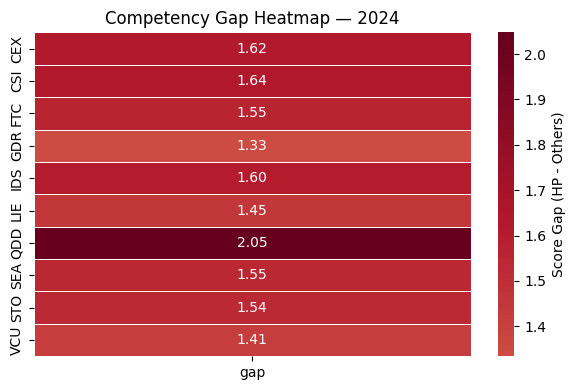

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung gap: HP - Others
gap = pivot.loc["High Performer"] - pivot.loc["Others"]
df_gap = pd.DataFrame({"gap": gap})
df_gap.index.name = "pillar_code"
df_gap = df_gap.reset_index()

plt.figure(figsize=(6,4))
sns.heatmap(
    df_gap.pivot_table(values="gap", index="pillar_code"),
    annot=True, fmt=".2f",
    cmap="RdBu_r", center=0,
    linewidths=.5, cbar_kws={"label": "Score Gap (HP - Others)"}
)

plt.title("Competency Gap Heatmap — 2024")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

Gap kompetensi terbesar terlihat pada kemampuan eksekusi dan penciptaan nilai strategis.
Pilar QDD, FTC, SEA, STO, dan CEX menjadi indikator kinerja tinggi yang paling konsisten.
Soft skills menjadi penentu utama success pattern di organisasi ini.

In [30]:
query = """
select 
    c.employee_id,
    c.pillar_code,
    c.score::numeric as score
from competencies_yearly c
join performance_yearly pr 
  on pr.employee_id = c.employee_id 
 and pr.year = c.year
where c.year = 2024
  and pr.rating = 5
"""
hp_comp = sql_df(query, engine)
hp_comp.head()


,employee_id,pillar_code,score
0,EMP100011,GDR,5.0
1,EMP100022,GDR,5.0
2,EMP100041,GDR,4.0
3,EMP100051,GDR,5.0
4,EMP100052,GDR,5.0


In [31]:
hp_pivot = hp_comp.pivot_table(
    index="employee_id",
    columns="pillar_code",
    values="score",
    aggfunc="mean"
).reset_index()

hp_pivot.head()

pillar_code,employee_id,CEX,CSI,FTC,GDR,IDS,LIE,QDD,SEA,STO,VCU
0,EMP100011,5.0,NaN,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0
1,EMP100022,5.0,5.0,4.0,5.0,5.0,NaN,5.0,5.0,5.0,5.0
2,EMP100041,5.0,NaN,5.0,4.0,4.0,NaN,5.0,NaN,5.0,5.0
3,EMP100051,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0
4,EMP100052,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0


In [32]:
pillars = ["CEX","CSI","FTC","GDR","IDS","LIE","QDD","SEA","STO","VCU"]
hp_pivot = hp_pivot[["employee_id"] + pillars]

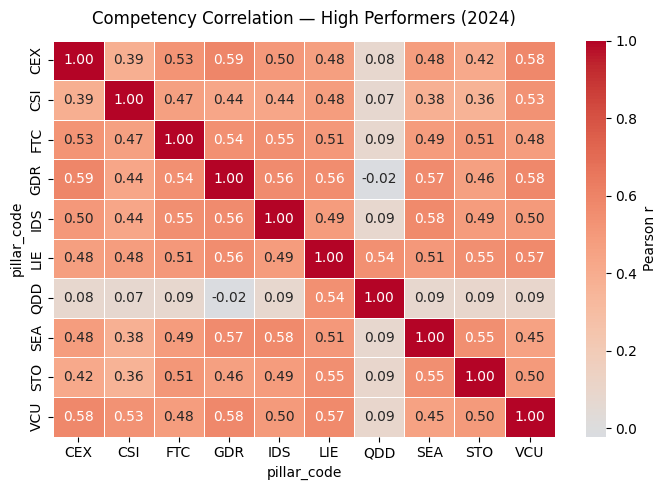

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = hp_pivot[pillars].corr(method="pearson")

plt.figure(figsize=(7,5))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    linewidths=.5, cbar_kws={"label":"Pearson r"}
)
plt.title("Competency Correlation — High Performers (2024)", pad=12)
plt.tight_layout()
plt.show()

Pilar FTC, QDD, dan SEA menunjukkan korelasi yang konsisten positif (0.49–0.57)<br>
High Performers yang bisa cepat, biasanya juga rapi dan adaptif.

STO, VCU, dan IDS saling terhubung kuat, korelasi berada di kisaran 0.50–0.59<br>
Mereka berkontribusi pada tujuan jangka panjang dan fokus menciptakan nilai bagi pelanggan & bisnis.

GDR, LIE, CSI membentuk cluster soft power dengan korelasi 0.44–0.56<br>
High Performers bukan hanya individual star, tapi mampu menggerakkan orang lain & menjaga kepercayaan.

Kompetensi High Performers membentuk sistem yang saling memperkuat:<br>
leadership → execution → value creation → iteration improvement

### **Section D — Behavioral data**

In [34]:
query = """
select
  case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
  s.theme,
  count(*) as frequency
from strengths s
join performance_yearly pr
  on pr.employee_id = s.employee_id and pr.year = 2024
where pr.rating between 1 and 5
  and s.rank <= 5   -- Top 5 themes
group by 1,2
order by group_label, frequency desc;
"""
sql_df(query, engine)

,group_label,theme,frequency
0,High Performer,NaN,78
1,High Performer,Strategic,38
2,High Performer,Deliberative,35
3,High Performer,Woo,34
4,High Performer,Empathy,34
...,...,...,...
65,Others,Relator,209
66,Others,Developer,208
67,Others,Significance,205
68,Others,Connectedness,197


**Success Formula Draft v1**
| TGV                           |   Bobot | Rasionale                             |
| ----------------------------- | ------: | ------------------------------------- |
| Competency Performance        | **60%** | Pembeda paling dominan & data lengkap |
| Leadership & Influence Traits | **25%** | Strategic + Influence + Ownership     |
| Cognitive Efficiency (Pauli)  | **15%** | Stamina cognitive mendukung performa  |


In [35]:
query = """
select 
  case when pr.rating = 5 then 'High Performer' else 'Others' end as group_label,
  s.theme
from strengths s
join performance_yearly pr
  on pr.employee_id = s.employee_id and pr.year = 2024
where pr.rating between 1 and 5
  and s.rank <= 5
"""
df_strengths = sql_df(query, engine)

In [36]:
count_df = (
    df_strengths
    .groupby(["group_label", "theme"])
    .size()
    .reset_index(name="count")
)

# total per group untuk normalisasi
totals = count_df.groupby("group_label")["count"].sum()
count_df["proportion"] = count_df.apply(
    lambda row: row["count"] / totals[row["group_label"]],
    axis=1
)

In [37]:
top_HP = (
    count_df[count_df["group_label"]=="High Performer"]
    .sort_values("proportion", ascending=False)
    .head(10)
)
themes_to_plot = top_HP["theme"].tolist()

# Filter untuk kedua grup
plot_df = count_df[count_df["theme"].isin(themes_to_plot)]

In [38]:
plot_df_clean = plot_df[plot_df["theme"].notna()].copy()

# hitung selisih proporsi (HP - Others)
pivot_prop = plot_df_clean.pivot(index="theme", columns="group_label", values="proportion")
pivot_prop["gap"] = pivot_prop["High Performer"] - pivot_prop["Others"]

# Urutkan berdasarkan gap terbesar → smallest
pivot_prop = pivot_prop.sort_values("gap", ascending=False)
pivot_prop

group_label,High Performer,Others,gap
theme,,,
Strategic,0.038776,0.027392,0.011383
Deliberative,0.035714,0.026675,0.009040
Empathy,0.034694,0.026077,0.008617
Woo,0.034694,0.027990,0.006703
Consistency,0.032653,0.027751,0.004902
Responsibility,0.032653,0.027751,0.004902
Focus,0.031633,0.027153,0.004480
Futuristic,0.032653,0.028708,0.003945
Positivity,0.031633,0.028947,0.002685


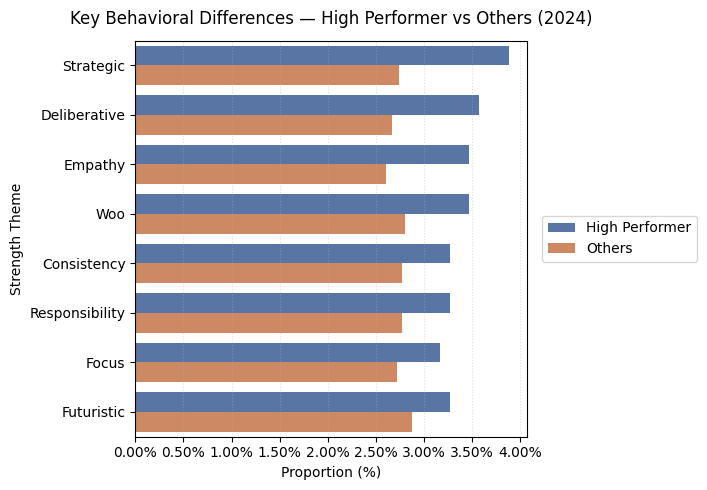

In [39]:
import matplotlib.ticker as mtick

top_themes = pivot_prop.head(8).reset_index()
melt_df = top_themes.melt(id_vars="theme", value_vars=["High Performer","Others"], 
                          var_name="group_label", value_name="proportion")

plt.figure(figsize=(8.5,5))
sns.barplot(
    data=melt_df,
    x="proportion",
    y="theme",
    hue="group_label",
    palette=["#4c72b0","#dd8452"]
)

plt.xlabel("Proportion (%)")
plt.ylabel("Strength Theme")
plt.title("Key Behavioral Differences — High Performer vs Others (2024)", pad=12)

# Format x-axis to percentage
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Move legend outside
plt.legend(title="", loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room on right for legend
plt.show()

High Performers lebih sering menunjukkan pola perilaku kepemimpinan strategis,
pengambilan keputusan mempertimbangkan risiko, dan orientasi pada hasil.
Mereka bukan hanya deliver, tetapi menggerakkan tim menuju tujuan.

## **Executive Summary — Step 1**
Talent Match Intelligence: Success Pattern Discovery

Berbasis analisis data Performance 2024 terhadap 1.868 karyawan (196 High Performers), ditemukan bahwa:
1. Experience is NOT a differentiator<br>
• Distribusi Years of Service High Performers hampir identik dengan Others<br>
• Senioritas bukan penentu performa tinggi<br>
• High Performer bisa muncul dari early-career talent<br>

📌 Fokus harus bergeser ke kapabilitas, bukan masa kerja

2. Cognitive only plays a minor role<br>
• Pauli score High Performers sedikit lebih tinggi<br>
• Effect size (Cohen’s d) sangat kecil: 0.11<br>
• IQ & GTQ tidak menunjukkan perbedaan signifikan<br>

📌 Cognitive endurance mendukung kesuksesan, namun tidak mendefinisikan

3. Competency is the primary success driver

Radar chart & gap analysis menunjukkan selisih >1.3 hingga 2.05 poin pada seluruh pilar, terutama:
| Pilar         | Insight                          |
| ------------- | -------------------------------- |
| **QDD**       | Quality & Problem Solving        |
| **FTC**       | Speed of Execution               |
| **SEA**       | Agility                          |
| **CEX / STO** | Customer & Strategic Orientation |

📌 High Performers consistent → They deliver better and faster<br>
📌 Competencies = the #1 predictor of success

4. Behavioral patterns enhance impact

Strength Themes yang paling membedakan High Performers:
| Behavioral Strengths               | Description                        |
| ---------------------------------- | ---------------------------------- |
| Strategic, Futuristic              | Direction-setting ability          |
| Responsibility, Focus, Consistency | Ownership & execution discipline   |
| Empathy, Woo                       | Influence & stakeholder management |

📌 High Performers aren’t just skilled — they move people forward and get things done

### ***Success Formula: Data-Backed TGV Structure***
| TGV                                         | Bobot | Faktor Kunci       |
| ------------------------------------------- | ----: | ------------------ |
| **Execution Excellence**                    |   40% | QDD, FTC, SEA      |
| **Strategic Value Orientation**             |   35% | CEX, STO, VCU, IDS |
| **Collaboration & Leadership**              |   25% | CSI, GDR, LIE      |
| **(+ Cognitive Efficiency bonus opsional)** |  +10% | Pauli              |

📌 Ini mencerminkan cara performa muncul: Skill → Behavior → Impact

## **Step 2 - Operationalize the Logic in SQL**

**Step 2.1 — menyiapkan Benchmark High Performer**

Benchmark = average score HP 2024 per pillar <br>
Output ini nantinya digunakan untuk “persentase pencapaian” per karyawan.

In [40]:
query = """
with benchmark as (
    select 
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as baseline_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id and pr.year = c.year
    where c.year = 2024
      and pr.rating = 5
      and c.score <= 5
    group by c.pillar_code
)
select * from benchmark order by pillar_code;
"""
sql_df(query, engine)

,pillar_code,baseline_score
0,CEX,4.690608
1,CSI,4.634831
2,FTC,4.691011
3,GDR,4.672131
4,IDS,4.636364
5,LIE,4.662921
6,QDD,4.666667
7,SEA,4.726776
8,STO,4.584699
9,VCU,4.604278


**Step 2.2 Hitung rata-rata score kompetensi per karyawan (tahun 2024) dan pivot setiap pilar menjadi kolom**

In [41]:
query = """
-- Employee Competency Pivot Table
with benchmark as (
    select 
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as baseline_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id and pr.year = c.year
    where c.year = 2024
      and pr.rating = 5
      and c.score <= 5
    group by c.pillar_code
),
emp_comp as (
    select 
        c.employee_id,
        c.pillar_code,
        avg(c.score::numeric) as avg_score
    from competencies_yearly c
    join performance_yearly pr
      on pr.employee_id = c.employee_id
     and pr.year = c.year
    where c.year = 2024
      and pr.rating between 1 and 5
    group by c.employee_id, c.pillar_code
)
select 
    employee_id,
    max(case when pillar_code='CEX' then avg_score end) as CEX,
    max(case when pillar_code='CSI' then avg_score end) as CSI,
    max(case when pillar_code='FTC' then avg_score end) as FTC,
    max(case when pillar_code='GDR' then avg_score end) as GDR,
    max(case when pillar_code='IDS' then avg_score end) as IDS,
    max(case when pillar_code='LIE' then avg_score end) as LIE,
    max(case when pillar_code='QDD' then avg_score end) as QDD,
    max(case when pillar_code='SEA'  then avg_score end) as SEA,
    max(case when pillar_code='STO'  then avg_score end) as STO,
    max(case when pillar_code='VCU'  then avg_score end) as VCU
from emp_comp
group by employee_id
order by employee_id;
"""
sql_df(query, engine)

,employee_id,cex,csi,ftc,gdr,ids,lie,qdd,sea,sto,vcu
0,DUP1942,2.0,2.0,2.0,2.0,3.0,2.0,2.0,1.0,NaN,2.0
1,DUP2096,NaN,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0
2,DUP3015,4.0,4.0,4.0,5.0,4.0,4.0,4.0,NaN,4.0,5.0
3,DUP3452,3.0,NaN,3.0,2.0,4.0,4.0,3.0,2.0,3.0,2.0
4,DUP4177,NaN,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1863,EMP101995,5.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0
1864,EMP101996,5.0,5.0,5.0,NaN,5.0,5.0,5.0,5.0,5.0,4.0
1865,EMP101997,4.0,5.0,4.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0
1866,EMP101998,4.0,4.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0


Terlihat ada beberapa NaN skor kompetensi

Jika suatu kompetensi tidak ada datanya, maka match rate-nya diabaikan<br>
→ dihitung rata-rata hanya dari pilar yang tersedia

Jadi kita tidak menghapus talenta karena data missing.

**Step 2.3 — Hitung TV Match Rate (%)**

In [42]:
query = """
with benchmark as (
    select 
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as baseline_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id and pr.year = c.year
    where c.year = 2024
      and pr.rating = 5
      and c.score <= 5
    group by c.pillar_code
),
emp_comp as (
    select 
        c.employee_id,
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as avg_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id 
     and pr.year = c.year
    where c.year = 2024
      and pr.rating between 1 and 5
    group by c.employee_id, c.pillar_code
),
tv_match as (
    select 
        e.employee_id,
        e.pillar_code,
        (e.avg_score / b.baseline_score) * 100 as tv_match_rate
    from emp_comp e
    join benchmark b on b.pillar_code = e.pillar_code
)
select *
from tv_match
order by employee_id, pillar_code;
"""
sql_df(query, engine)

,employee_id,pillar_code,tv_match_rate
0,DUP1942,CEX,42.638398
1,DUP1942,CSI,43.151515
2,DUP1942,FTC,42.634731
3,DUP1942,GDR,42.807018
4,DUP1942,IDS,64.705882
...,...,...,...
18675,EMP101999,LIE,42.891566
18676,EMP101999,QDD,21.428571
18677,EMP101999,SEA,42.312139
18678,EMP101999,STO,43.623361


**Step 2.4 — Hitung skor TGV dan Final Success Score**

Rumus per TGV:

| TGV                        | Pilar              | Bobot |
| -------------------------- | ------------------ | ----: |
| Execution Excellence       | QDD, FTC, SEA      |  0.40 |
| Strategic Value            | STO, VCU, IDS, CEX |  0.35 |
| Collaboration & Leadership | CSI, GDR, LIE      |  0.25 |

TGV Score<br>
= Rata-rata tv_match_rate untuk pilar di TGV tersebut<br>
(tanpa NaN)

FINAL_SCORE (Success Score)<br>
= Σ (TGV_Score × Weight)

In [43]:
# query = """
# with emp_comp as (
#     select 
#         c.employee_id,
#         c.pillar_code,
#         avg(c.score::numeric) as avg_score
#     from competencies_yearly c
#     join performance_yearly pr 
#       on pr.employee_id = c.employee_id 
#      and pr.year = c.year
#     where c.year = 2024
#       and pr.rating between 1 and 5
#       and c.score <= 5
#     group by c.employee_id, c.pillar_code
# ),
# tv_match as (
#     select 
#         e.employee_id,
#         e.pillar_code,
#         (e.avg_score / b.benchmark_score) as ratio 
#     from emp_comp e
#     join benchmark b on b.pillar_code = e.pillar_code
# ),
# tgv as (
#     select 
#         employee_id,
#         avg(case when pillar_code in ('QDD','FTC','SEA') then ratio end) as exec_ratio,
#         avg(case when pillar_code in ('STO','VCU','IDS','CEX') then ratio end) as strat_ratio,
#         avg(case when pillar_code in ('CSI','GDR','LIE') then ratio end) as lead_ratio
#     from tv_match
#     group by employee_id
# ),
# final as (
#     select 
#         employee_id,
#         exec_ratio,
#         strat_ratio,
#         lead_ratio,
#         (
#             coalesce(nullif(exec_ratio, 'NaN')::numeric, 0) * 0.40 +
#             coalesce(nullif(strat_ratio, 'NaN')::numeric, 0) * 0.35 +
#             coalesce(nullif(lead_ratio, 'NaN')::numeric, 0) * 0.25
#         ) as success_ratio
#     from tgv
# )
# select 
#     employee_id,
#     exec_ratio * 100 as exec_score,
#     strat_ratio * 100 as strat_score,
#     lead_ratio * 100 as lead_score,
#     success_ratio * 100 as success_score
# from final
# where success_ratio is not null
# order by success_score desc;
# """
# sql_df(query, engine)

In [44]:
query = """
with benchmark as (
    select 
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as baseline_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id and pr.year = c.year
    where c.year = 2024
      and pr.rating = 5
      and c.score <= 5
    group by c.pillar_code
),
emp_comp as (
    select 
        c.employee_id,
        c.pillar_code,
        avg(c.score::numeric) as user_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id 
     and pr.year = c.year
    where c.year = 2024
      and pr.rating between 1 and 5
      and c.score <= 5
    group by c.employee_id, c.pillar_code
),
tv_match as (
    select 
        e.employee_id,
        e.pillar_code as tv_name,
        (e.user_score / b.baseline_score) * 100 as tv_match_rate,
        b.baseline_score,
        e.user_score
    from emp_comp e
    join benchmark b on b.pillar_code = e.pillar_code
),
tgv as (
    select 
        employee_id,
        avg(case when tv_name in ('QDD','FTC','SEA') 
                 then tv_match_rate end) as exec_match_rate,
        avg(case when tv_name in ('STO','VCU','IDS','CEX') 
                 then tv_match_rate end) as strat_match_rate,
        avg(case when tv_name in ('CSI','GDR','LIE') 
                 then tv_match_rate end) as lead_match_rate
    from tv_match
    group by employee_id
),
final_match as (
    select
        employee_id,
        exec_match_rate,
        strat_match_rate,
        lead_match_rate,
        (
            coalesce(nullif(exec_match_rate, 'NaN')::numeric, 0) * 0.40 +
            coalesce(nullif(strat_match_rate, 'NaN')::numeric, 0) * 0.35 +
            coalesce(nullif(lead_match_rate, 'NaN')::numeric, 0) * 0.25
        ) as final_match_rate
    from tgv
),
final_output as (
    select 
        f.employee_id,
        e.position_id as role,
        e.directorate_id as directorate,
        e.grade_id as grade,
        tm.tv_name,
        case 
            when tm.tv_name in ('QDD','FTC','SEA') then 'Execution Excellence'
            when tm.tv_name in ('STO','VCU','IDS','CEX') then 'Strategic Value'
            when tm.tv_name in ('CSI','GDR','LIE') then 'Leadership & Influence'
        end as tgv_name,
        tm.baseline_score,
        tm.user_score,
        tm.tv_match_rate,
        case 
            when tm.tv_name in ('QDD','FTC','SEA') then f.exec_match_rate
            when tm.tv_name in ('STO','VCU','IDS','CEX') then f.strat_match_rate
            when tm.tv_name in ('CSI','GDR','LIE') then f.lead_match_rate
        end as tgv_match_rate,
        f.final_match_rate
    from final_match f
    left join tv_match tm on tm.employee_id = f.employee_id
    join employees e on e.employee_id = f.employee_id
)
select *
from final_output
where final_match_rate is not null
order by final_match_rate desc, employee_id;
"""
sql_df(query, engine)

,employee_id,role,directorate,grade,tv_name,tgv_name,baseline_score,user_score,tv_match_rate,tgv_match_rate,final_match_rate
0,EMP100098,3,1,3,QDD,Execution Excellence,4.666667,5.0,107.142857,107.142857,107.508980
1,EMP100098,3,1,3,IDS,Strategic Value,4.636364,5.0,107.843137,108.023048,107.508980
2,EMP100098,3,1,3,VCU,Strategic Value,4.604278,5.0,108.594657,108.023048,107.508980
3,EMP100098,3,1,3,GDR,Leadership & Influence,4.672131,5.0,107.017544,107.375082,107.508980
4,EMP100098,3,1,3,STO,Strategic Value,4.584699,5.0,109.058403,108.023048,107.508980
...,...,...,...,...,...,...,...,...,...,...,...
17170,EMP101465,6,3,3,SEA,Execution Excellence,4.726776,1.0,21.156069,21.300669,21.430131
17171,EMP101902,6,3,3,CEX,Strategic Value,4.690608,1.0,21.319199,27.057530,9.470135
17172,EMP101902,6,3,3,IDS,Strategic Value,4.636364,1.0,21.568627,27.057530,9.470135
17173,EMP101902,6,3,3,STO,Strategic Value,4.584699,2.0,43.623361,27.057530,9.470135


**Step 2.5 Talent Categorization + Succession Ranking Output**

kita akan melakukan pengkategorian dengan range sebagai berikut:

| success_score | Category                               | Meaning                          |
| ------------: | -------------------------------------- | -------------------------------- |
|        ≥ 105% | **High Potential (Strong Successor)**  | Calon suksesi kuat               |
|       95–105% | **Strong Performer (Ready soon)**      | Siap pengembangan jadi successor |
|        < 95%  | **Development Priority**               | Fokus coaching                   |


In [45]:
query = """
with benchmark as (
    select 
        c.pillar_code,
        avg(c.score::numeric) FILTER (WHERE c.score IS NOT NULL AND c.score <> 'NaN') as baseline_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id and pr.year = c.year
    where c.year = 2024
      and pr.rating = 5
      and c.score <= 5
    group by c.pillar_code
),
emp_comp as (
    select 
        c.employee_id,
        c.pillar_code,
        avg(c.score::numeric) as user_score
    from competencies_yearly c
    join performance_yearly pr 
      on pr.employee_id = c.employee_id 
     and pr.year = c.year
    where c.year = 2024
      and pr.rating between 1 and 5
      and c.score <= 5
    group by c.employee_id, c.pillar_code
),
tv_match as (
    select 
        e.employee_id,
        e.pillar_code as tv_name,
        (e.user_score / b.baseline_score) * 100 as tv_match_rate,
        b.baseline_score,
        e.user_score
    from emp_comp e
    join benchmark b on b.pillar_code = e.pillar_code
),
tgv as (
    select 
        employee_id,
        avg(case when tv_name in ('QDD','FTC','SEA') 
                 then tv_match_rate end) as exec_match_rate,
        avg(case when tv_name in ('STO','VCU','IDS','CEX') 
                 then tv_match_rate end) as strat_match_rate,
        avg(case when tv_name in ('CSI','GDR','LIE') 
                 then tv_match_rate end) as lead_match_rate
    from tv_match
    group by employee_id
),
final_match as (
    select
        employee_id,
        exec_match_rate,
        strat_match_rate,
        lead_match_rate,
        (
            coalesce(nullif(exec_match_rate, 'NaN')::numeric, 0) * 0.40 +
            coalesce(nullif(strat_match_rate, 'NaN')::numeric, 0) * 0.35 +
            coalesce(nullif(lead_match_rate, 'NaN')::numeric, 0) * 0.25
        ) as final_match_rate
    from tgv
),
final_output as (
    select 
        f.employee_id,
        e.position_id as role,
        e.directorate_id as directorate,
        e.grade_id as grade,
        tm.tv_name,
        case 
            when tm.tv_name in ('QDD','FTC','SEA') then 'Execution Excellence'
            when tm.tv_name in ('STO','VCU','IDS','CEX') then 'Strategic Value'
            when tm.tv_name in ('CSI','GDR','LIE') then 'Leadership & Influence'
        end as tgv_name,
        tm.baseline_score,
        tm.user_score,
        tm.tv_match_rate,
        case 
            when tm.tv_name in ('QDD','FTC','SEA') then f.exec_match_rate
            when tm.tv_name in ('STO','VCU','IDS','CEX') then f.strat_match_rate
            when tm.tv_name in ('CSI','GDR','LIE') then f.lead_match_rate
        end as tgv_match_rate,
        f.final_match_rate
    from final_match f
    left join tv_match tm on tm.employee_id = f.employee_id
    join employees e on e.employee_id = f.employee_id
)
select
    f.employee_id,
    f.role,
    f.directorate,
    f.grade,
    f.tv_name,
    f.tgv_name,
    f.baseline_score,
    f.user_score,
    f.tv_match_rate,
    f.tgv_match_rate,
    f.final_match_rate,
    case 
        when f.final_match_rate >= 105 then 'Strong Successor'
        when f.final_match_rate >= 95 then 'Ready Soon'
        else 'Development Priority'
    end as talent_category
from final_output f
where f.final_match_rate is not null
order by f.final_match_rate desc;
"""
df_final = sql_df(query, engine)

In [46]:
df_final.head(15)

,employee_id,role,directorate,grade,tv_name,tgv_name,baseline_score,user_score,tv_match_rate,tgv_match_rate,final_match_rate,talent_category
0,EMP100098,3,1,3,CEX,Strategic Value,4.690608,5.0,106.595995,108.023048,107.508980,Strong Successor
1,EMP100098,3,1,3,VCU,Strategic Value,4.604278,5.0,108.594657,108.023048,107.508980,Strong Successor
2,EMP100098,3,1,3,IDS,Strategic Value,4.636364,5.0,107.843137,108.023048,107.508980,Strong Successor
3,EMP100098,3,1,3,GDR,Leadership & Influence,4.672131,5.0,107.017544,107.375082,107.508980,Strong Successor
4,EMP100098,3,1,3,STO,Strategic Value,4.584699,5.0,109.058403,108.023048,107.508980,Strong Successor
5,EMP100098,3,1,3,QDD,Execution Excellence,4.666667,5.0,107.142857,107.142857,107.508980,Strong Successor
6,EMP100098,3,1,3,LIE,Leadership & Influence,4.662921,5.0,107.228916,107.375082,107.508980,Strong Successor
7,EMP100098,3,1,3,CSI,Leadership & Influence,4.634831,5.0,107.878788,107.375082,107.508980,Strong Successor
8,EMP101390,1,1,3,CSI,Leadership & Influence,4.634831,5.0,107.878788,107.375082,107.402968,Strong Successor
9,EMP101390,1,1,3,LIE,Leadership & Influence,4.662921,5.0,107.228916,107.375082,107.402968,Strong Successor


C:\Users\user\AppData\Local\Temp\ipykernel_17256\1274527631.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\user\AppData\Local\Temp\ipykernel_17256\1274527631.py:9: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(


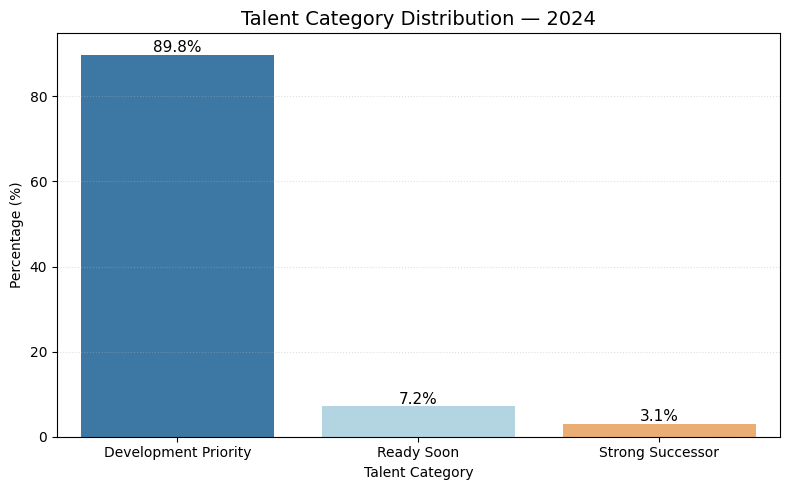

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung jumlah per kategori
cat_counts = df_final['talent_category'].value_counts().sort_values(ascending=False)
cat_percent = (cat_counts / cat_counts.sum() * 100).round(1)

plt.figure(figsize=(8,5))
sns.barplot(
    x=cat_percent.index,
    y=cat_percent.values,
    palette=["#2c7bb6","#abd9e9","#fdae61","#d7191c"]  # urut dari bagus ke perlu perhatian
)

plt.title("Talent Category Distribution — 2024", fontsize=14)
plt.xlabel("Talent Category")
plt.ylabel("Percentage (%)")

# Tambahkan label di atas bar
for i, v in enumerate(cat_percent.values):
    plt.text(i, v + 0.5, f"{v}%", ha='center', fontsize=11)

plt.ylim(0, max(cat_percent.values) + 5)
plt.grid(axis='y', linestyle=":", alpha=0.4)
plt.tight_layout()
plt.show()

Saat ini performa kuat ditopang oleh sedikit talenta unggulan.<br>
Untuk keberlanjutan bisnis, organisasi harus bergerak cepat memperbesar talent pool yang siap tampil.

We need to grow more leaders, faster.

In [48]:
df_final[df_final['employee_id'] == 'EMP100109']

,employee_id,role,directorate,grade,tv_name,tgv_name,baseline_score,user_score,tv_match_rate,tgv_match_rate,final_match_rate,talent_category
321,EMP100109,2,3,3,IDS,Strategic Value,4.636364,5.0,107.843137,102.693248,105.421138,Strong Successor
322,EMP100109,2,3,3,STO,Strategic Value,4.584699,5.0,109.058403,102.693248,105.421138,Strong Successor
323,EMP100109,2,3,3,GDR,Leadership & Influence,4.672131,5.0,107.017544,107.375082,105.421138,Strong Successor
324,EMP100109,2,3,3,CEX,Strategic Value,4.690608,4.0,85.276796,102.693248,105.421138,Strong Successor
325,EMP100109,2,3,3,VCU,Strategic Value,4.604278,5.0,108.594657,102.693248,105.421138,Strong Successor
326,EMP100109,2,3,3,FTC,Execution Excellence,4.691011,5.0,106.586826,106.586826,105.421138,Strong Successor
327,EMP100109,2,3,3,LIE,Leadership & Influence,4.662921,5.0,107.228916,107.375082,105.421138,Strong Successor
328,EMP100109,2,3,3,CSI,Leadership & Influence,4.634831,5.0,107.878788,107.375082,105.421138,Strong Successor


## **Step 3 - Build the AI Talent App & Dashboard**

🎯 Tujuan:

Talent Match Intelligence Dashboard dikembangkan untuk memberdayakan para pemimpin SDM dan manajer lini dalam mengidentifikasi alasan keberhasilan karyawan berprestasi dan untuk mengidentifikasi calon penerus yang menunjukkan kekuatan dan profil kesiapan serupa.

Sistem ini menerjemahkan data mentah organisasi menjadi wawasan bakat yang dapat ditindaklanjuti melalui analitik terintegrasi, visualisasi, dan narasi berbasis AI.

🧩 Key Features

🧭 Vacancy Definition<br>
Para pemimpin menentukan benchmark role, job level, dan purpose, lalu memilih benchmark employees (high performers) sebagai success models.
Langkah ini memastikan analisis tetap spesifik terhadap role dan selaras dengan keunggulan kinerja aktual.

🤖 AI-Generated Job Profile<br>
LLM (OpenRouter) secara otomatis menghasilkan job profile yang ringkas, merinci key competencies, behavioral traits, dan faktor kinerja yang dibutuhkan untuk sukses dalam role tersebut. Fitur ini menjembatani konteks bisnis dan interpretasi data dengan mulus.

📊 Talent Match Summary<br>
Dashboard memvisualisasikan readiness pipeline dalam 3 kategori yaitu:
1. Strong Successor (≥105%)
2. Ready Soon (≥95%)
3. Development Priority (<80%)

Insights ini mengungkap kedalaman suksesi dan potensi risiko bakat.

🏅 Candidate Ranking<br>
Semua karyawan diperingkat berdasarkan Final Match Rate mereka, yang menggabungkan Execution, Strategic, and Leadership dimensions..
Tabel ini menyediakan quick filters dan kemampuan ekspor untuk tinjauan SDM atau penggunaan dalam rapat suksesi.

🧩 Distribution & Readiness Visualization<br>
Interactive histograms and correlation plots merangkum bagaimana talenta organisasi terdistribusi di berbagai tingkat readiness—memungkinkan para pemimpin untuk mengukur kekuatan kandidat secara sekilas.

🔬 Candidate Deep Dive<br>
Untuk setiap karyawan terpilih, dasbor menyediakan analisis kesenjangan TGV (Talent Growth Vector) yang menunjukkan area strength dan development opportunity dibandingkan dengan benchmark data.

🎯 AI Advisory Narrative<br>

Powered by OpenRouter LLM, dasbor ini secara otomatis menghasilkan HR advisory summary per candidate, yang terdiri dari:
1. Readiness assessment
2. Strength highlights
3. Development recommendations (6–12 months horizon)

Hal ini memungkinkan HR untuk menggabungkan presisi data dengan penilaian manusia untuk keputusan perencanaan suksesi.

💡 Impact<br>
✅ Data-driven succession planning: Dari intuisi hingga penilaian kesiapan berbasis analitik.<br>
✅ Scalable framework: Mudah direplikasi di berbagai peran, jenjang, dan unit bisnis.<br>
✅ Storytelling for decision-making: Mengubah metrik menjadi narasi yang dapat ditindaklanjuti bagi para pemangku kepentingan non-teknis.<br>
✅ AI-assisted advisory: menyediakan development roadmaps yang ringkas untuk setiap potential successor.

🏁 Outcome<br>
The Talent Match Intelligence Dashboard memberikan pandangan terpadu yang didukung AI tentang potensi bakat organisasi.<br>
Hal ini memungkinkan tim HR untuk melihat patterns of success, measure readiness, dan memandu development decisions dengan jelas, tepat, dan percaya diri.

"From performance data to succession insight — Talent Match Intelligence helps leaders see not just who performs today, but who will lead tomorrow."